In [1]:
## https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook
## https://blog.naver.com/tngus4334/222633939904

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#import warnings
#warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [3]:
#데이터 불러오기
train = pd.read_csv('/Users/eunji/Downloads/titanic/train.csv')
test = pd.read_csv('/Users/eunji/Downloads/titanic/test.csv')
IDtest = test['PassengerId']

In [4]:
#Outlier detection
def detect_outliers(df, n, features) :
    outlier_indices = []
    
    #iterate over features :
    for col in features :
        #1st quartile(25%)
        Q1 = np.percentile(df[col], 25)
        #3rd quartile(75%)
        Q3 = np.percentile(df[col], 75)
        #InterQuartile range(IQR)
        IQR = Q3 - Q1
        
        #Outtlier Step
        outlier_step = 1.5 * IQR
        
        #Determine a list of indices of outliers for teature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step)|(df[col] > Q3 + outlier_step)].index
        
        #append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    #select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
    
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [5]:
#이상치가 있는 행 추출
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
#이상치가 있는 행 제거
#axis = 0
#reset_index : 행 인덱스 초기화, 인덱스를 데이터 열로 추가
#reset_index(drop=True) : 인덱스 열 drop
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [7]:
#train의 길이
train_len = len(train)

#학습데이터와 테스트데이터를 합침
dataset = pd.concat(objs=[train, test], axis = 0).reset_index(drop=True)

In [8]:
#dataset의 결측값을 nan값으로 채움
dataset = dataset.fillna(np.nan)

In [9]:
#결측값 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [10]:
#train의 전반적인 정보
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [11]:
#train의 결측값 확인
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [12]:
#train의 데이터형식
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
#train의 통계랑
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


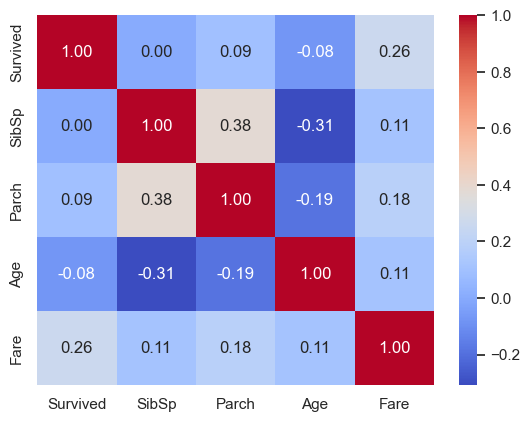

In [14]:
#train의 Survived, SibSp, Parch, Age, Fare의 상관관계에 대한 heatmap 생성
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt=".2f", cmap = "coolwarm")

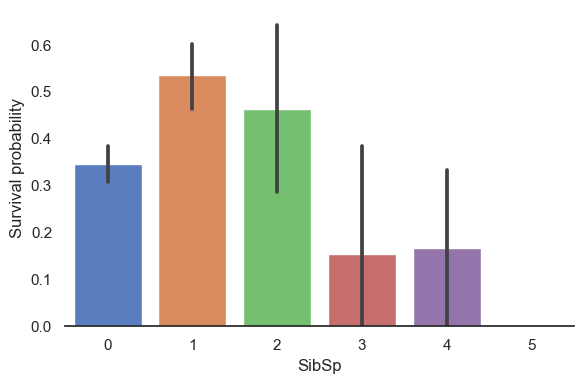

In [15]:
#x축을 SibSp로 하고 y축을 Survived로 하는 bar 형태의 catplot 생성
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=4, aspect=1.5, palette="muted")

#g의 왼쪽축 제거
g.despine(left=True)

#y축 이름 지정
g = g.set_ylabels("Survival probability")

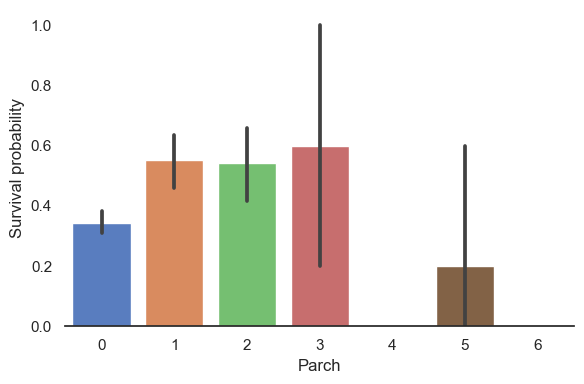

In [16]:
#Parch
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=4, aspect=1.5, palette="muted")

g.despine(left=True)
g = g.set_ylabels("Survival probability")

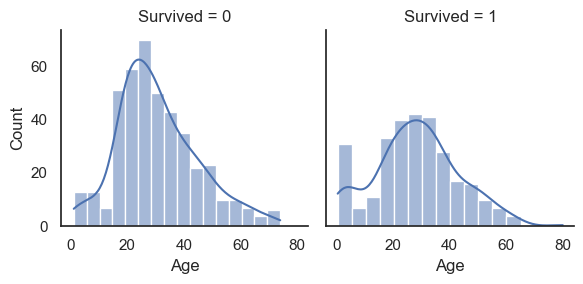

In [64]:
#Age : Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age", kde= True)

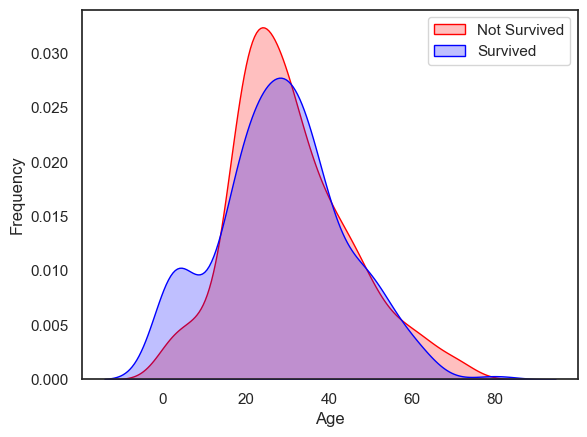

In [18]:
#연령 분포 확인
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax = g, color="Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

In [19]:
#Fare의 결측값 확인
dataset["Fare"].isnull().sum()

1

In [20]:
#Fare의 중앙값으로 결측값 채움
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

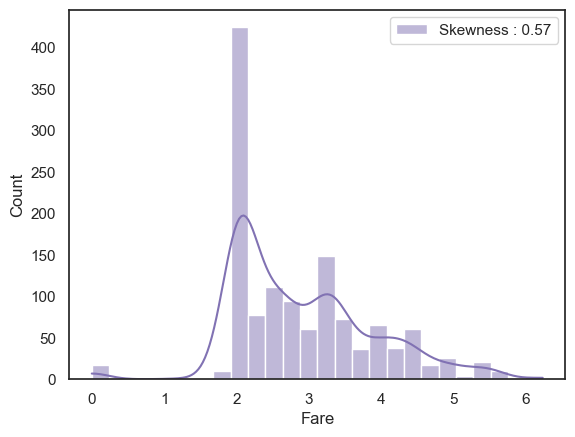

In [65]:
g = sns.histplot(dataset["Fare"], color="m", kde=True, label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [22]:
#Fare값을 log함수로 변환
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i > 0 else 0)

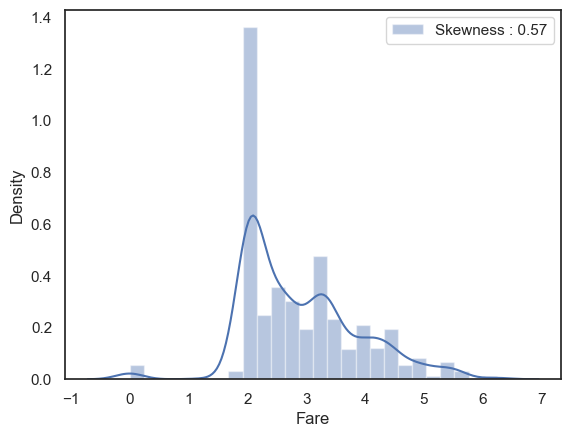

In [23]:
#distribution plot을 그림
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))

#범례표시
g = g.legend(loc="best")

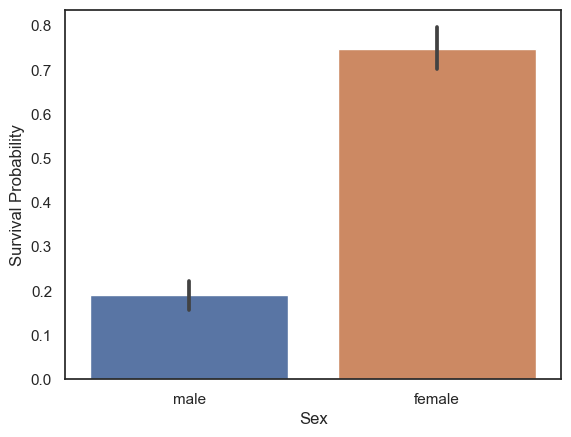

In [50]:
#x축을 Sex, y축을 Survived로 하는 막대그래프 그림
g = sns.barplot(x="Sex", y="Survived", data=train)

#y축 이름 지정
g = g.set_ylabel("Survival Probability")

In [25]:
#Sex별 Survived의 평균
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


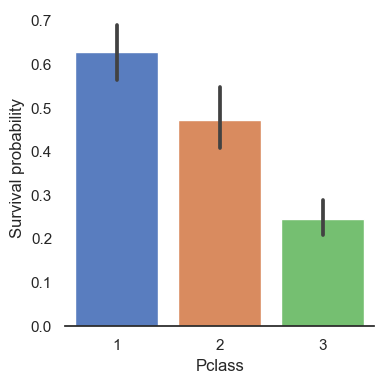

In [47]:
#x축을 Pclass, y축을 Survived로 하는 bar 형식의 catplot 그림
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=4, aspect=1, palette = "muted")

#g의 왼쪽축 제거
g.despine(left=True)

#y축 이름 지정
g = g.set_ylabels("Survival probability")

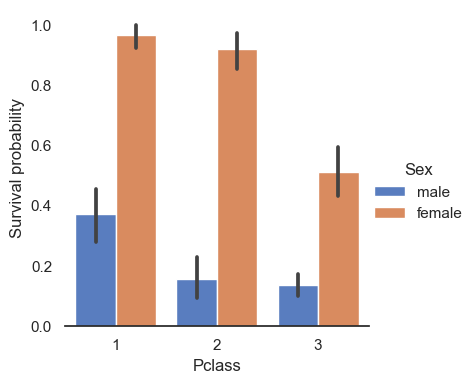

In [27]:
#x축을 Pclass, y축을 Survived로 하는 bar 형식의 catplot을 Sex에 따라 나눠 그림
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, 
                height=4, aspect=1, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

In [28]:
#Embarked의 결측값 확인
dataset["Embarked"].isnull().sum()

2

In [29]:
#빈도수가 가장 높은 S로 결측값 채움
dataset["Embarked"] = dataset["Embarked"].fillna("S")

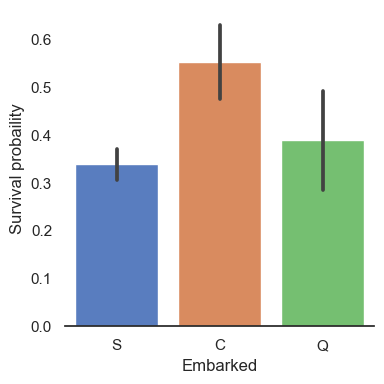

In [30]:
#x축을 Embarked, y축을 Survived로 하는 bar 형식의 catplot 그림
g = sns.catplot(x="Embarked", y="Survived", data=train,
               height=4, aspect=1, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probaility")

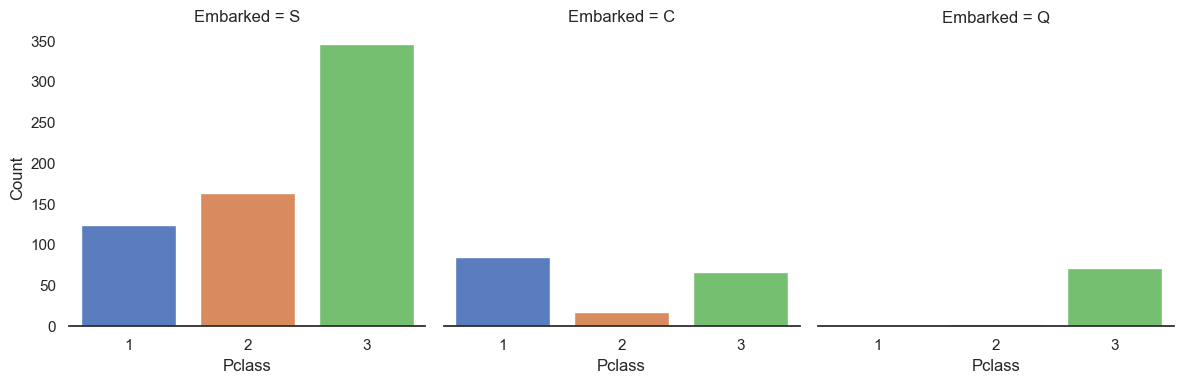

In [31]:
#Pclass에 따른 탑승객 수를 bar 형식의 catplot으로 Embarked에 따라 나눠 그림
g = sns.catplot(x="Pclass", col="Embarked", data=train,
               height=4, aspect=1, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

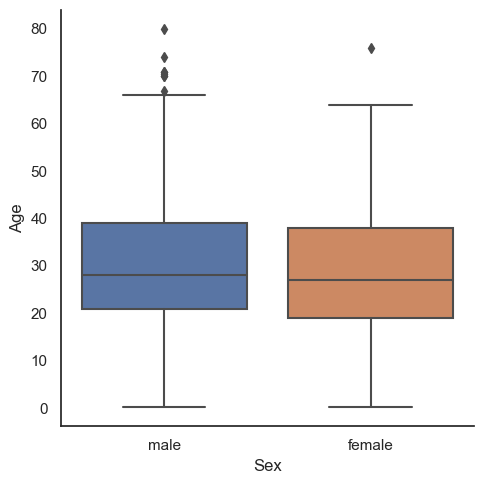

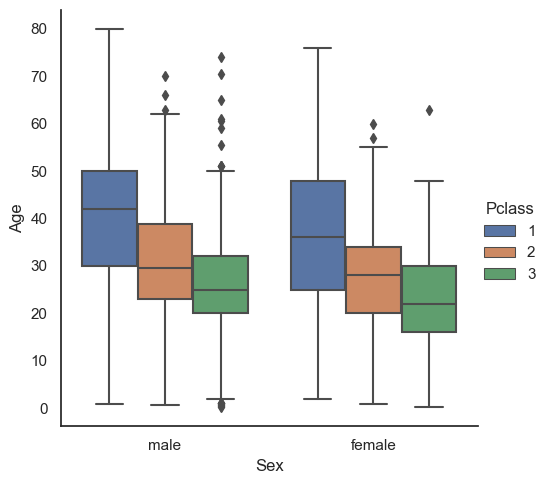

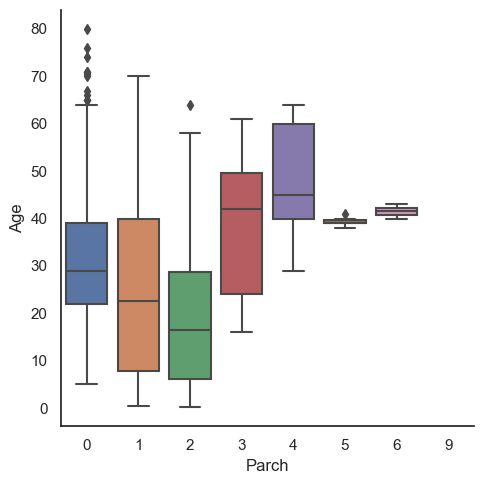

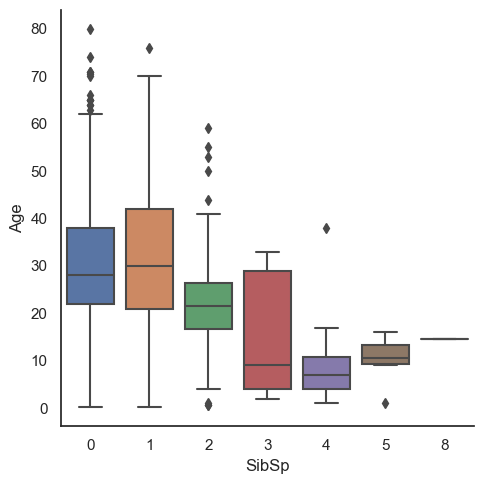

In [32]:
#x축을 Sex, y축을 Age로 하는 box 형식의 catplot 그림
g = sns.catplot(y="Age", x="Sex", data=dataset, kind="box")

#x축을 Sex, y축을 Age로 하는 box 형식의 catplot을 Pclass에 따라 나눠 그림
g = sns.catplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")

#x축을 Parch, y축을 Age로 하는 box 형식의 catplot 그림
g = sns.catplot(y="Age", x="Parch", data=dataset, kind="box")

#x축을 SibSp, y축을 Age로 하는 box 형식의 catplot 그림
g = sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")

In [33]:
#남성은 0, 여성은 1로 범주화
dataset["Sex"] = dataset["Sex"].map({"male" :0, "female" :1})

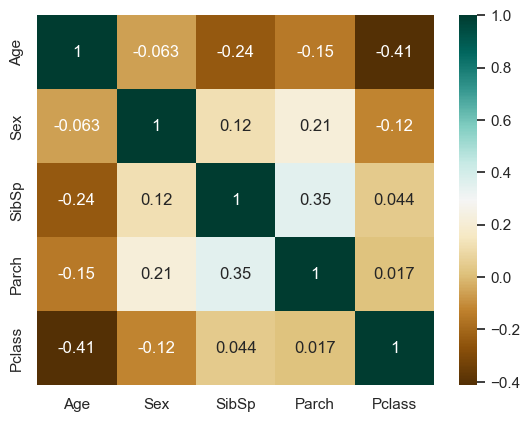

In [34]:
#dataset의 Age, Sex, SibSp, Parch, Pclass의 상관관계에 대한 heatmap 생성
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [35]:
#dataset에서 Age가 결측값인 행을 모두 뽑아냄
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"])
                              & (dataset['Parch'] == dataset.iloc[i]["Parch"])
                              & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

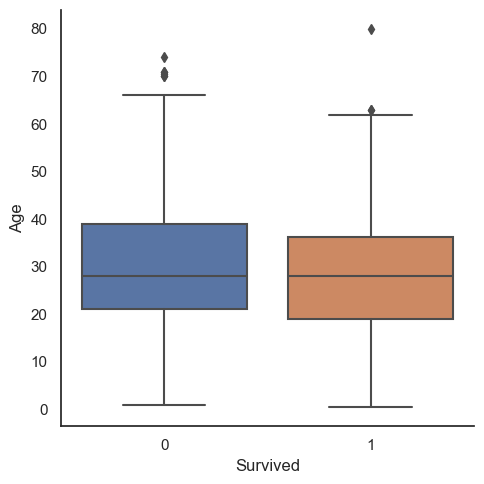

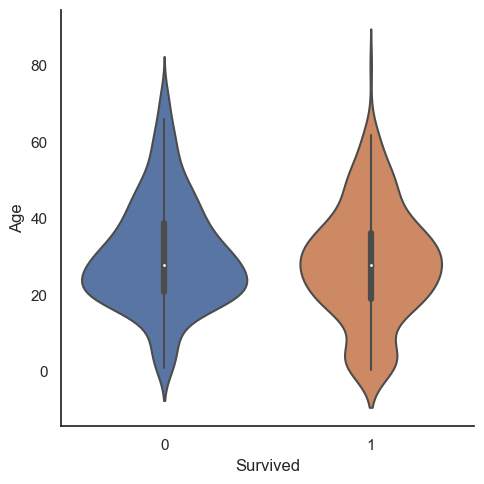

In [36]:
#x축을 Survived, y축을 Age로 하는 box형식의 catplot 그림
g = sns.catplot(x="Survived", y="Age", data=train, kind="box")

#x축을 Survived, y축을 Age로 하는 box형식의 violin 그림
g = sns.catplot(x="Survived", y="Age", data=train, kind="violin")

In [37]:
#dataset의 Name 변수를 봄
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [38]:
#title을 뽑아냄
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]

#Series로 변경
dataset["Title"] = pd.Series(dataset_title)

#데이터 출력
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

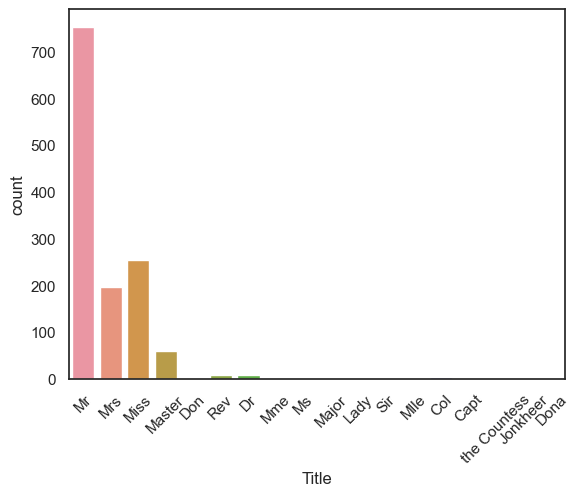

In [39]:
#Title에 따른 빈도수 그래프
g = sns.countplot(x="Title", data=dataset)

#그래프의 x라벨 기울기 설정
g = plt.setp(g.get_xticklabels(), rotation=45)

In [40]:
#흔하지 않은 Title을 rare로 변경
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')

#0,1,2,3으로 Title을 범주화
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms":1, "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})

In [41]:
#정수형태로 변환
dataset["Title"] = dataset["Title"].astype(int)

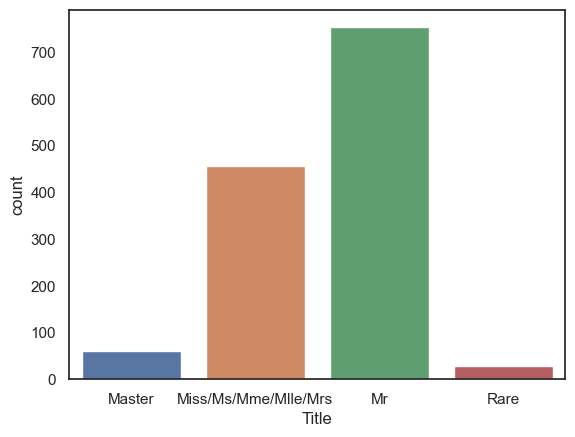

In [57]:
#Title에 따른 빈도수 그래프를 그림
g = sns.countplot(x="Title", data=dataset)

#x축 이름 지정
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

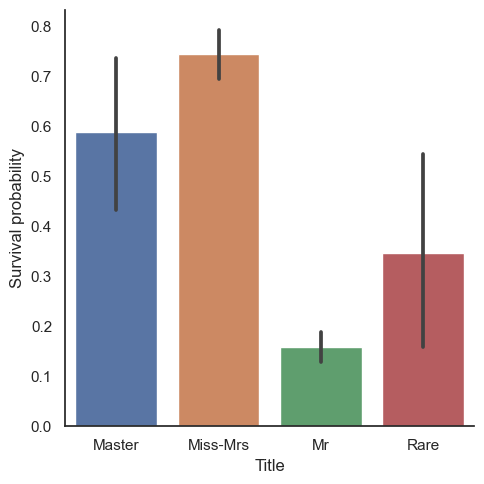

In [56]:
#x축을 Title로 하고 y축을 Survived로 하는 bar 형태의 factorplot 생성
g = sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")

#x축 이름 지정
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])

#y축 이름 지정
g = g.set_ylabels("Survival probability")

In [ ]:
#Name 변수 drop
dataset.drop(labels = ["Name"], axis=1, inplace=True)

In [ ]:
#Family size : Fsize(가족규모) = SibSp(형제/자매수)+Parch(부모/자식수) + 1(나)
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

In [ ]:
#x축을 Title로 하고 y축을 Survived로 하는 bar 형태의 catplot 생성
g = sns.catplot(x="Fsize", y="Survived", data=dataset, kind="point")

#y축 이름 지정
g = g.set_ylabels("Survival probability")

In [ ]:
#Fsize가 1이면 single
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)

#Fsize가 2이면 SmallF
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)

#Fsize가 3,4이면 MedF
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)

#Fsize가 5이상이면 LargeF
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [ ]:
g = sns.catplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival probability")
g = sns.catplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival probability")
g = sns.catplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival probability")

In [ ]:
#Title을 더미변수화
dataset = pd.get_dummies(dataset, columns = ["Title"])

#Embarked를 더미변수화
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [ ]:
dataset.head()

In [ ]:
#Cabin(객실번호) 출력
dataset["Cabin"].head()

In [ ]:
dataset["Cabin"].describe()

In [ ]:
#Cabin의 결측값(객실이 없는 승객)
dataset["Cabin"].isnull().sum()

In [ ]:
#Cabin 중 결측값이 아닌 데이터 출력
dataset["Cabin"][dataset["Cabin"].notnull()].head()

In [ ]:
#Cabin 결측치를 x로
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

In [ ]:
g = sns.countplot(x="Cabin", data=dataset, order=['A','B','C','D','E','F','G','T','X'])

In [ ]:
g = sns.catplot(y="Survived",x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [ ]:
#Cabin을 더미변수화
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [ ]:
#Ticket(티켓번호) 출력
dataset["Ticket"].head()

In [ ]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
        

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

In [ ]:
#Ticket을 더미변수화
dataset = pd.get_dummies(dataset, columns = ["Ticket"],prefix="T")

In [ ]:
#카테고리 형태로 변환
dataset["Pclass"] = dataset["Pclass"].astype("category")

#Pclass를 더미변수화
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [ ]:
#PassengerId를 drop
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
#dataset 출력
dataset.head()

In [ ]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1, inplace=True)

In [ ]:
#Train features와 label 분리
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

In [ ]:
#교차 검증 모델 
kfold = StratifiedKFold(n_splits=10)

In [ ]:
#모델링 단계 테스트
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))

classifiers.append(DecisionTreeClassifier(random_state=random_state))

classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))

classifiers.append(RandomForestClassifier(random_state=random_state))

classifiers.append(ExtraTreesClassifier(random_state=random_state))

classifiers.append(GradientBoostingClassifier(random_state=random_state))

classifiers.append(MLPClassifier(random_state=random_state))

classifiers.append(KNeighborsClassifier())

classifiers.append(LogisticRegression(random_state = random_state))

classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring = "accuracy", cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradienBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data=cv_res,palette="Set3",orient="h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
#최적의 모델을 위한 하이파라미터 튜닝
#AdaBoost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" : ["best","random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" : [1,2],
                  "learning_rate":[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

In [ ]:
gsadaDTC.best_score_

In [ ]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

#Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                "max_features":[1, 3, 10],
                "min_samples_split":[2, 3, 10],
                "min_samples_leaf":[1, 3, 10],
                "bootstrap":[False],
                "n_estimators":[100, 300],
                "criterion":["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

#Best score
gsExtC.best_score_

In [ ]:
#RFC Parameters tunning
RFC = RandomForestClassifier()

#Search grid for optimal parameters
rf_param_grid = {"max_depth":[None],
                "max_features":[1, 3, 10],
                "min_samples_split":[2, 3, 10],
                "min_samples_leaf":[1, 3, 10],
                "bootstrap":[False],
                "n_estimators":[100, 300],
                "criterion":["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

#Best score
gsRFC.best_score_

In [ ]:
#Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss':["log_loss"],
                'n_estimators':[100, 200, 300],
                'learning_rate':[0.1, 0.05, 0.01],
                'max_depth':[4, 8],
                'min_samples_leaf':[100, 150],
                'max_features':[0.3, 0.1]}

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold,
                    scoring="accuracy", n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

#Best score
gsGBC.best_score_

In [ ]:
#SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001, 0.01, 0.1, 1],
                 'C':[1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

#Best score
gsSVMC.best_score_

In [ ]:
#Plot learning curves : 훈련 세트에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향 확인
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + "feature importance")
        nclassifier += 1

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
#앙상블 모델링 : Combining models
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best),('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
#예측 : 예측 및 결과 제출
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv("ensemble_python_voting.csv", index=False)